* Librerias:

In [1]:
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

* Funciones:
    - CrearGrafico, Creación del gráfico final.
    - getDatos, obtención de los datos del repo de GitHub CSSEGISandData.
    - getInfo, recuperar los valores de última importación y número de casos del DataFrame.

In [2]:
def CrearGrafico(df, Titulo):
    Ultima_Importacion = df['Fecha'][-1:].max()
        
    df.set_index('Fecha', inplace = True)
    Grafico = df.plot(kind = 'line'
                      , linestyle= '--'
                      , linewidth = 1.5
                      , color=['black','green','red','grey']
                      , figsize = (14.36 / 1.5, 7.09 / 1.5))
    
    Grafico.tick_params(left = False, bottom = False)
    Grafico.grid(axis = 'y', alpha=0.25)
    Grafico.fmt_xdata = mdates.DateFormatter('%m')
    Grafico.legend(loc = 'upper center'
               , bbox_to_anchor = (0.5, 1.2)
               , ncol = 4
               , fancybox = False
               , shadow = True
               , fontsize = 12)
    
    Grafico.text(len(df) * 0.3
                 , plt.gca().get_yticks().max() - plt.gca().get_yticks().max() / len(plt.gca().get_yticks())
                 , 'Tasa de mortalidad:  {:.2f}% '.format(- df[-1:]['Muertes'].sum() / (df[-1:]['Altas'].sum() - df[-1:]['Muertes'].sum()) * 100)
                 , fontsize = 12
                 , bbox = dict(facecolor='none'
                               , edgecolor='none'
                               , boxstyle='square'
                               , pad = 1))

    [spine.set_visible(False) for spine in plt.gca().spines.values()]
    plt.gca().set_yticklabels([str(locale.format_string('%.0f',x , True)).replace(',','.') for x in plt.gca().get_yticks()])
    plt.gca().set_ylabel(str(locale.format_string('%.0f', df[-1:]['Enfermos'].sum(), True)).replace(',','.') + ' - ' + Titulo 
                         , color = '#909090'
                         , fontsize = 15)

    plt.gca().set_xlabel('* Datos actualizados a: ' + Ultima_Importacion
                         , color = '#909090'
                         , x = 0.85
                         , fontsize = 10)

    plt.xticks(rotation = 0)
    plt.show()
    plt.close()
    
    return Grafico

In [3]:
def getDatos(param, Pais):
    Url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/' + param['Tabla'] + '.csv'

    df = (pd.read_csv(Url, sep = ',', header = 0)
          .drop(['Province/State','Lat','Long'], axis='columns')
          .rename(columns = {'Country/Region':'Pais'}))

    df = (df[(df['Pais'] == Pais)]
          .set_index('Pais')
          .transpose()
          .reset_index()
          .rename(columns = {Pais:param['Campo'],'index':'Fecha'}))

    df = df[(df['Fecha'] > '2/29/20')]
    df['Fecha'] =  pd.to_datetime(df['Fecha'], format = '%m/%d/%y').dt.strftime('%d-%b')
    
    return df

### Obtención de datos y creación de gráfico

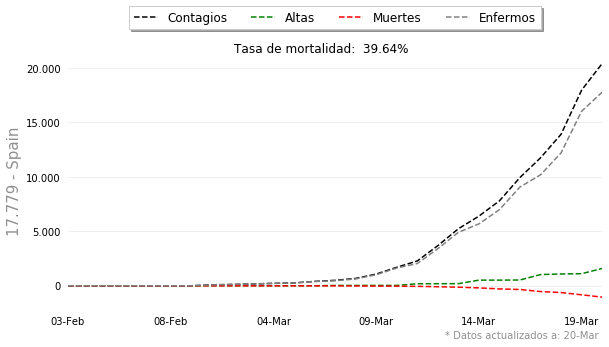

In [4]:
query = [{'Tabla':'time_series_19-covid-Confirmed'
         ,'Campo':'Contagios'}
        ,{'Tabla':'time_series_19-covid-Recovered'
         ,'Campo':'Altas'}
        ,{'Tabla':'time_series_19-covid-Deaths'
         ,'Campo':'Muertes'}] 

Pais = 'Spain'
df = getDatos(query[0], Pais)
for i in range(len(query) - 1): 
    df = pd.merge(df, getDatos(query[i + 1], Pais), on='Fecha')
    
df.loc[df['Fecha'] == '12-Mar', query[0]['Campo']] = 3680
df.loc[df['Fecha'] == '12-Mar', query[1]['Campo']] = 189
df.loc[df['Fecha'] == '12-Mar', query[2]['Campo']] = 89

df['Enfermos'] = df.Contagios - df.Altas - df.Muertes

df.Muertes *= -1
CrearGrafico(df, Pais)

In [5]:
def getDatos(param, CCAA):
    Url = 'https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019/ccaa_covid19_' + param['Tabla'] + '.csv'

    df = (pd.read_csv(Url, sep = ',', header = 0)
              .drop(['cod_ine'], axis='columns')
              .rename(columns = {'Country/Region':'Pais'}))

    df = (df[(df['CCAA'] == CCAA)]
              .set_index('CCAA')
              .transpose()
              .reset_index()
              .rename(columns = {CCAA:param['Campo'],'index':'Fecha'}))
    
    df['Fecha'] =  pd.to_datetime(df['Fecha'], format = '%d/%m/%Y').dt.strftime('%d-%b')
    return df

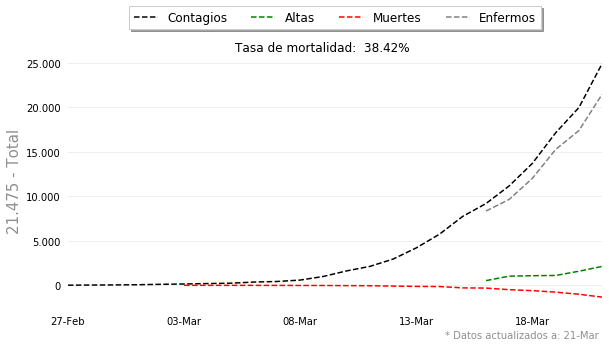

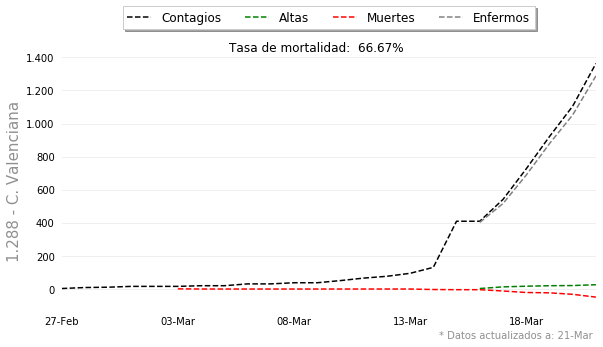

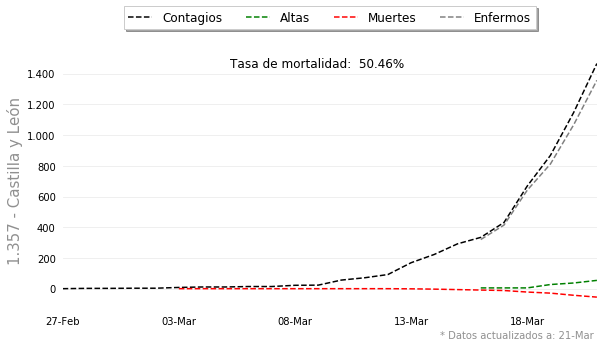

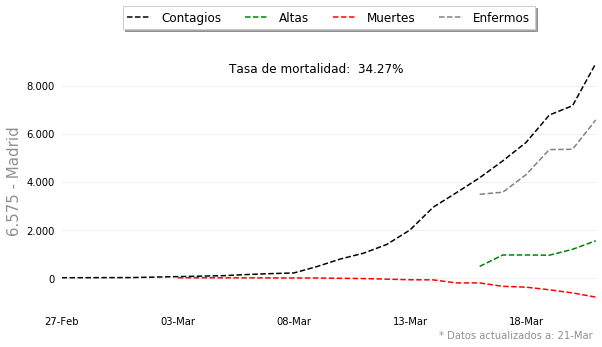

In [6]:
query = [{'Tabla':'casos'
         ,'Campo':'Contagios'}
        ,{'Tabla':'altas'
         ,'Campo':'Altas'}
        ,{'Tabla':'fallecidos'
         ,'Campo':'Muertes'}]

CCAAs = ['Total','C. Valenciana','Castilla y León','Madrid']

for x in CCAAs: 
    Pais = x
    df = getDatos(query[0], Pais)

    for i in range(len(query) - 1): 
        df = pd.merge(df, getDatos(query[i + 1], Pais), on = 'Fecha', how='left')
        df
        
    df['Enfermos'] = df.Contagios - df.Altas - df.Muertes

    df.Muertes *= -1
    CrearGrafico(df, Pais)
